<a href="https://colab.research.google.com/github/yfwang09/ShElastic/blob/master/examples/Test02_SH_Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elasticity Quantities in Spherical Harmonic Space

In this notebook, we derive the spherical harmonics representation of elasticity quantities: displacement, stress and traction. It is also a test script for `shelastic.shelastic` module. To run all test, click **Kernel/Restart & Run All**. The test result is at the very end of the notebook.

In [1]:
# If you run this notebook on colab, run this cell
import os
codepath = '/content/ShElastic'
if not os.path.exists(codepath):
    !git clone https://github.com/yfwang09/ShElastic.git 
    !pip install pyshtools
os.chdir(os.path.join(codepath, 'examples'))

Cloning into 'ShElastic'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1126 (delta 18), reused 8 (delta 3), pack-reused 1081
Receiving objects: 100% (1126/1126), 146.48 MiB | 32.88 MiB/s, done.
Resolving deltas: 100% (404/404), done.
     |████████████████████████████████| 10.8MB 324kB/s 


## The derivation of displacement solution

From (Barber 3rd ed.):

$$
2\mu\mathbf{u} = -4(1-\nu)\mathbf{\psi} + \nabla(\mathbf{r}\cdot\mathbf{\psi})
$$

where the vector potential $\mathbf{\psi} = \omega\hat{\mathbf{e}}_k,\; k = x,y,z$, and $\omega$ is harmonic function. (i.e. $\nabla^2\omega=0$)

### (a) test case: Kelvin's solution

The displacement solution of a point force multipole at origin evaluated on a unit sphere can be represented by the Green Function. We first define the Green Function:

$$
G_{ij} = \frac{1}{8\pi\mu}\big[\delta_{ij}R,_{kk}-\frac{1}{2(1-\nu)}R,_{ij}\big]
$$

Then we can write the displacement in $m=(x,y,z)$ direction:

$$
u_k^{(m)}=G_{mk}=\frac{1}{8\pi\mu}\big[\delta_{mk}R,_{pp}-\frac{1}{2(1-\nu)}R,_{mk}\big]
$$

where $R=\sqrt{x^2+y^2+z^2}$ is the radius of the point from the origin. $\mu$ and $\nu$ are shear modulus and Poisson's ratio respectivily.
We have proved (**to do**) that the Papkovich-Neuber Solution B with the solid harmonic of degree $l = 0$ is consistent with the Kelvin's solution. We can use Kelvin's solution as our test case to verify the solution.

We then develop the test case based on Kelvin's solution:

1. Create a 3D mesh grid `[-10:10, -10:10, -10:10]` for evaluate the displacement;
2. Calculate the expression of the second derivative of R;
3. Evaluate the expression at the mesh grid points;
4. Composite the displacement solution.

First, we create the meshgrid, and define the parameters ($\mu=2.65,\;\nu=0.25$):

In [2]:
import numpy as np
import sys, os
sys.path.append('..')
from shelastic.shutil import CartCoord_to_SphCoord, SphCoord_to_CartCoord

# Material properties
MU = 2.65
NU = 0.25

# Define mesh
normalization='4pi'
# normalization='ortho'
# normalization='schmidt'
shtype = 'irr'
lmax = 3
xgrid = np.linspace(-10, 10, 20)
# The order (Y,X,Z) makes sure that axis 0,1,2 corresponds to X,Y,Z
Y, X, Z = np.meshgrid(xgrid, xgrid, xgrid)
R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)
LAT = 90 - np.rad2deg(THETA)
LON = np.rad2deg(PHI)

Based on the result of `second_deriv_R_sym()`, we can write a routine that can directly evaluate the derivative without evaluate the symbolic expressions.

In [3]:
from shelastic.SHTest import second_deriv_R, third_deriv_R

In [4]:
Rij = second_deriv_R(X, Y, Z)

term1 = np.zeros(R.shape+(3, 3))
term2 = np.zeros(R.shape+(3, 3))

for m in range(3):
    for k in range(3):
        Rpp = Rij[0][0]+Rij[1][1]+Rij[2][2]
        term1[:,:,:,m,k] = term1[:,:,:,m,k] + (m==k) * Rpp
        term2[:,:,:,m,k] = term2[:,:,:,m,k] + Rij[m][k]

u_test = (1/(8*MU*np.pi)) * ( term1 - term2/(2*(1-NU)) )

### (b) Implementation

Then we apply the Papkovich-Neuber Solution B.

In [5]:
import pyshtools
from shelastic.shgrad import SHMultiplyC, VSH1, VSH2
from shelastic.shutil import eval_GridC

We first develop a code snippet to calculate the dot product of the spherical harmonic vector and the normal vector $\hat{\mathbf{r}}$:

In [6]:
def rdotPsi(l, m, k, c_omega=1.0, lmax=100):
    Ylm = pyshtools.SHCoeffs.from_zeros(lmax, kind='complex')
    Ylm.set_coeffs(c_omega, l, m)
    return VSH1(Ylm.to_array())[...,k]

Then we use the vector spherical harmonics and rdot functions to derive the Papkovich-Neuber solution B:

For regular and irregular solid harmonics, the equations can be simplified as:

(a). Irregular solid harmonics:

$$
2\mu\mathbf{u}^{l,m,k}=
    -4(1-\nu)\hat{\mathbf{e}}_{k}\frac{Y_l^m}{r^{l+1}}+
        \nabla\big(x_{k}\frac{Y_l^m}{r^{l+1}}\big) = \\
    -4(1-\nu)\hat{\mathbf{e}}_{k}\frac{Y_l^m}{r^{l+1}}+
        \left[\frac{-l\hat{\mathbf{r}}}{r^{l+1}}\frac{x_{k}Y_l^m}{r}+
        \frac{1}{r^{l}}\nabla\big(\frac{x_{k}Y_l^m}{r}\big)\right]
$$
$$
2\mu r^{l+1}\mathbf{u}^{l,m,k}= 
    -4(1-\nu)\hat{\mathbf{e}}_{k}Y_l^m
    -l\hat{\mathbf{r}}\frac{x_{k}Y_l^m}{r}+r\nabla\big(\frac{x_{k}Y_l^m}{r}\big) =
    2\mu(U_{\nu}^{(K)} + U_{irr}^{(K)})
$$

(b). Regular solid harmonics:

$$
2\mu\mathbf{u}^{l,m,k}=
    -4(1-\nu)\hat{\mathbf{e}}_{k}r^lY_l^m+
        \nabla\big(x_{k}r^lY_l^m\big) = \\
    -4(1-\nu)\hat{\mathbf{e}}_{k}r^lY_l^m+
        \Big[(l+1)r^l\hat{\mathbf{r}}\frac{x_{k}Y_l^m}{r}+
        r^{l+1}\nabla\big(\frac{x_{k}Y_l^m}{r}\big)\Big]
$$
$$
2\mu r^{-l}\mathbf{u}^{l,m,k}=
    -4(1-\nu)\hat{\mathbf{e}}_{k}Y_l^m+
        (l+1)\hat{\mathbf{r}}\frac{x_{k}Y_l^m}{r}+
        r\nabla\left(\frac{x_{k}Y_l^m}{r}\right) =
    2\mu(U_{\nu}^{(K)} + U_{reg}^{(K)})
$$

where $2\mu U_{\nu}^{(K)} = -4(1-\nu)\hat{\mathbf{e}}_kY_l^m$ is the displacement part that is depending on the Poisson's ratio.

kind = 'complex'
normalization = '4pi'
csphase = 1
lmax = 3
header = None
kind = 'complex'
normalization = '4pi'
csphase = 1
lmax = 3
header = None
kind = 'complex'
normalization = '4pi'
csphase = 1
lmax = 3
header = None


/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


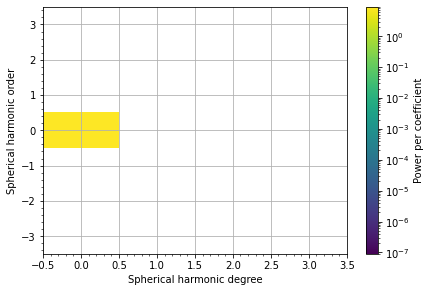

In [7]:
import matplotlib.pyplot as plt

c_omega = -1/6/np.pi
l = 0
m = 0
k = 2
U_nu = [pyshtools.SHCoeffs.from_zeros(lmax=lmax, kind='complex') for x in range(3)]
U_nu[k].set_coeffs(-4*(1-NU), l, m)
U_nu[0].info()
U_nu[1].info()
U_nu[2].info()
fig, ax = U_nu[2].plot_spectrum2d(vrange=(1e-8, 1))
Unu = np.stack((U_nu[0].to_array(),U_nu[1].to_array(),U_nu[2].to_array()), axis=-1)

And the part that is independent of Poisson's ratio is:

$$
2\mu U_{irr}^{(K)} = -l\hat{\mathbf{r}}\frac{x_{k}Y_l^m}{r}+r\nabla\left(\frac{x_{k}Y_l^m}{r}\right), \quad
2\mu U_{reg}^{(K)} = (l+1)\hat{\mathbf{r}}\frac{x_{k}Y_l^m}{r}+r\nabla\left(\frac{x_{k}Y_l^m}{r}\right)
$$

or in terms of vector spherical harmonics:

$$
2\mu U_{irr}^{(K)} = 
-l\mathcal{Y}\left[\hat{\mathbf{r}}\cdot\mathbf{\psi}\right] +
\mathcal{\Psi}[\hat{\mathbf{r}}\cdot\mathbf{\psi}], \quad
2\mu U_{reg}^{(K)} = 
(l+1)\mathcal{Y}\left[\hat{\mathbf{r}}\cdot\mathbf{\psi}\right] +
\mathcal{\Psi}[\hat{\mathbf{r}}\cdot\mathbf{\psi}]
$$

where the vector potential $\mathbf{\psi} = Y_l^m\hat{\mathbf{e}}_k$

In [8]:
rdP = rdotPsi(l, m, k, 1.0, lmax=lmax)
U_0 = -l*VSH1(rdP)+VSH2(rdP)
U = c_omega/2./MU*(Unu+U_0)

Then we evaluate the displacement on the grid to compare with Green Function solution:

In [9]:
Uk = [pyshtools.SHCoeffs.from_array(U[...,k],normalization='4pi',csphase=1) for k in range(3)]

u_2 = np.stack( [eval_GridC(Uk[i], LAT, LON)/R for i in range(3)], axis=-1)
#u_2 = np.stack( [Uk[i].expand(lat=LAT, lon=LON)/R for i in range(3)] , axis=-1)

np.set_printoptions(suppress=True)
print(u_2.shape)
rel_err = np.abs(u_2 - u_test[:,:,:,k,:]).mean()
print('Relative error is: %.8e'%rel_err)
if rel_err < 1e-10:
    testU1 = True
    print('Test case for displacement solution passed')
else:
    testU1 = False
    print('Test case for displacement solution failed')
#print(u_2/u_test[:,:,:,k,:])

(20, 20, 20, 3)
Relative error is: 3.19038771e-19
Test case for displacement solution passed


Then we implement the function `genUmode` that calculates displacement modes $U^{(l,m,k)}$ in `shelastic.shelastic`, and test it as following:

In [10]:
from shelastic.shelastic import genUmode, calUmode

Umode = genUmode(l, m, k)
U_3 = calUmode(Umode, mu=MU, nu=NU, c_omega=c_omega)
U_3 = [pyshtools.SHCoeffs.from_array(U_3[...,i]) for i in range(3)]

# u_3 = np.stack( [U_3[i].expand(lat=LAT, lon=LON)/R for i in range(3)] , axis=-1)
u_3 = np.stack( [eval_GridC(U_3[i], LAT, LON)/R for i in range(3)], axis=-1)
np.set_printoptions(suppress=True)
print(u_3.shape)
#print(u_3/u_test[:,:,:,k,:])
rel_err = np.abs(u_3 - u_test[:,:,:,k,:]).mean()
print('Relative error is: %.8e'%rel_err)
if rel_err < 1e-10:
    testU2 = True
    print('Test case for genUmode passed')
else:
    testU2 = False
    print('Test case for genUmode failed')

(20, 20, 20, 3)
Relative error is: 3.14512898e-19
Test case for genUmode passed


## Derivation of Stress solution

The strain can be written as:

$$
\mathbf{\varepsilon}^{l,m,(m)} = \frac{1}{2}(\nabla^T+\nabla)\mathbf{u}^{l,m,k}
$$

where the gradient of vector $\mathbf{u}$ can be calculated as:

$$
[\nabla\mathbf{u}_{irr}]_{ij} = \frac{\partial u_{irr,i}}{\partial x_j} =
\frac{-l-1}{r^{l+2}}\big[U^{l,m,k}_{irr,i}\frac{x_j}{r}\big] + 
\frac{1}{r^{l+2}}\big[r\frac{\partial}{\partial x_j}U^{l,m,k}_{irr,i}\big]
$$

$$
[\nabla\mathbf{u}_{reg}]_{ij} = \frac{\partial u_{reg,i}}{\partial x_j} =
lr^{l-1}\big[U^{l,m,k}_{reg,i}\frac{x_j}{r}\big] + 
r^{l-1}\big[r\frac{\partial}{\partial x_j}U^{l,m,k}_{reg,i}\big]
$$

where $U^{l,m,k}_{i}$ is the displacement solution of degree $l, m$ at $r=1$ developed before.

Then we will develop the stress:

$$
\sigma_{ij}^{k} = \lambda\delta_{ij}\varepsilon_{vv}^{k} + 2\mu\varepsilon_{ij} =
\lambda\delta_{ij}u_{v,\;v}^{k} + \mu(u^{k}_{i,\;j}+u^{k}_{j,\;i})
$$



### (a)  test case: Kelvin's solution

We first develop the Kelvin's stress solution analytically. The following solution is adapted from Wei's note:

$$
\sigma_{ij}^{(m)} = \frac{1}{8\pi}\big[\frac{\nu}{1-\nu}\delta_{ij}R_{,\,ppm} +
\delta_{i(m)}R_{,\,ppj} + \delta_{j(m)}R_{,\,ppi}-\frac{1}{1-\nu}R_{,\,(m)ij}\big]
$$

In [11]:
B = third_deriv_R(X, Y, Z)
Rijk = np.zeros(X.shape + (3, 3, 3))
for i in range(3):
    for j in range(3):
        for k in range(3):
            ind = i**2 + j**2 + k**2;
            Rijk[:, :, :, i, j, k] = B[ind];

term1 = np.zeros(Rijk.shape)
term2 = np.zeros(Rijk.shape)
term3 = np.zeros(Rijk.shape)
term4 = np.zeros(Rijk.shape)

for m_dir in range(3):
    for i in range(3):
        for j in range(3):
            temp1 = Rijk[:,:,:,0,0,m_dir]+ Rijk[:,:,:,1,1,m_dir]+ Rijk[:,:,:,2,2,m_dir]
            temp2 = Rijk[:,:,:,0,0,j]+ Rijk[:,:,:,1,1,j]+ Rijk[:,:,:,2,2,j]
            temp3 = Rijk[:,:,:,0,0,i]+ Rijk[:,:,:,1,1,i]+ Rijk[:,:,:,2,2,i]

            term1[:,:,:,m_dir,i,j] = term1[:,:,:,m_dir,i,j] + (i==j)* temp1
            term2[:,:,:,m_dir,i,j] = term2[:,:,:,m_dir,i,j] + (m_dir==i)* temp2
            term3[:,:,:,m_dir,i,j] = term3[:,:,:,m_dir,i,j] + (m_dir==j)* temp3
            term4[:,:,:,m_dir,i,j] = term4[:,:,:,m_dir,i,j] + Rijk[:,:,:,m_dir,i,j]

sigma_t = (1/(8*np.pi))*( NU/(1-NU)*term1 + term2 + term3 - 1/(1-NU)*term4 )

### (b) Implementation

Then we implement the `genSmode` in `shelastic.shelastic`, and perform test here:

In [12]:
from shelastic.shelastic import genSmode, calSmode

import time

tic = time.time()
Smode = genSmode(l, m, k)
S_K = calSmode(Smode, mu=MU, nu=NU, c_omega=c_omega)
toc = time.time()
print('Generating mode K time %.4fs'%(toc-tic))
S_2 = np.empty(X.shape + (3, 3))
tic = time.time()
for i in range(3):
    for j in range(3):
        S_Kij = pyshtools.SHCoeffs.from_array(S_K[...,i,j], normalization='4pi', csphase=1)
        #S_2[:,:,:,i,j] = np.real(S_Kij.expand(lat=LAT, lon=LON))/R**2
        S_2[:,:,:,i,j] = np.real(eval_GridC(S_Kij, LAT, LON))/R**2
toc = time.time()
print('Evaluation time %.4fs'%(toc-tic))
np.set_printoptions(suppress=True)
print(S_2.shape)
# print(S_2/sigma_t[:,:,:,k,:,:])
rel_err = np.abs(S_2 - sigma_t[:,:,:,k,:]).mean()
print('Relative error is: %.8e'%rel_err)
if rel_err < 1e-10:
    testS = True
    print('Test case for stress solution genSmode passed')
else:
    testS = False
    print('Test case for stress solution genSmode failed')

Generating mode K time 0.0087s
Evaluation time 0.7954s
(20, 20, 20, 3, 3)
Relative error is: 4.87419580e-19
Test case for stress solution genSmode passed


### (c) numerical test

We come back to the equilibrium condition to test the stress solution numerically:

$$
\nabla\cdot\sigma=0\quad\sigma_{ij,j}=0
$$

In [13]:
# The order (Y,X,Z) makes sure that axis 0,1,2 corresponds to X,Y,Z
normalization='4pi'
# normalization='ortho'
# normalization='schmidt'
shtype = 'irr'
lmax = 3
xgrid = np.linspace(-1, 1, 30)
#zgrid = np.linspace(-1, 1, 3)
Y, X, Z = np.meshgrid(xgrid, xgrid, xgrid)
R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)
LAT = 90 - np.rad2deg(THETA)
LON = np.rad2deg(PHI)

MU = 2.65
NU = 0.25

In [14]:
l = 4
m = 3
k = 0
Smode = genSmode(l, m, k, shtype='reg')
Scoeff= calSmode(Smode, mu=MU, nu=NU)
S_grid = np.zeros(R.shape + (3, 3))
for i in range(3):
    for j in range(3):
        Sij = pyshtools.SHCoeffs.from_array(Scoeff[...,i,j])
        S_grid[:,:,:,i,j] = np.real(Sij.expand(lat=LAT, lon=LON)*R**(l-1))

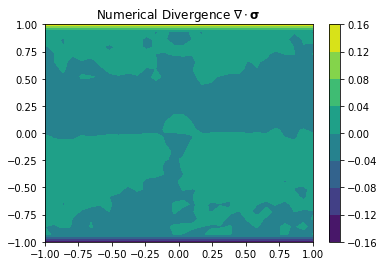

In [15]:
f0 = np.gradient(np.real(S_grid[:,:,:,1,0]), X[:,0,0],Y[0,:,0],Z[0,0,:])[0] +\
     np.gradient(np.real(S_grid[:,:,:,1,1]), X[:,0,0],Y[0,:,0],Z[0,0,:])[1] +\
     np.gradient(np.real(S_grid[:,:,:,1,2]), X[:,0,0],Y[0,:,0],Z[0,0,:])[2]

#plt.figure(figsize=(6,5))
zplane = 10
plt.title(r'Numerical Divergence $\nabla\cdot\mathbf{\sigma}$')
plt.contourf(X[:,:,zplane],Y[:,:,zplane],f0[:,:,zplane])
plt.colorbar()
plt.show()

This result shows that the divergence of the stress solution is 0, which satisfies the equilibrium condition.

## Traction solution

Then based on the stress solution, we can calculate the traction vector as:

$$
\mathbf{T} = \mathbf{\sigma}\cdot\mathbf{n}
$$

which is implemented in `shelastic.shelastic` as `calTmode`

## Test the fast evaluation using scipy

In [17]:
from scipy.special import sph_harm
from shelastic.shutil import sparse_mode
import time

Ngrid = 50
theta = np.arange(2*Ngrid)/Ngrid*np.pi
phi = np.arange(Ngrid)/Ngrid*np.pi
THETA, PHI = np.meshgrid(theta, phi)
l = 4
m = 0
k = 0
Smode = genSmode(l, m, k, shtype='reg')
Scoeff= calSmode(Smode, mu=MU, nu=NU)
print(Scoeff.shape)
for u in range(3):
    for v in range(3):
        print(u, v)
        sparseSlm = np.nonzero(np.abs(Scoeff[...,u,v]) > 1e-8)
        print(sparseSlm)
        l_list = sparseSlm[1]
        m_list = sparseSlm[2]*((-1)**sparseSlm[0])
        c_list = Scoeff[...,u,v][sparseSlm]
        print('l:', l_list)
        print('m:', m_list)
        print('c:', c_list)
        tic = time.time()
        sigma_uv = sph_harm(m_list, l_list, THETA[...,np.newaxis], PHI[...,np.newaxis])
        toc = time.time()
        sigma_uv *= ((-1.)**m_list)*c_list*np.sqrt(4*np.pi)
        print(sigma_uv.shape, toc-tic)

(2, 8, 8, 3, 3)
0 0
(array([0, 0, 0, 1, 1, 1]), array([1, 3, 3, 1, 3, 3]), array([1, 1, 3, 1, 1, 3]))
l: [1 3 3 1 3 3]
m: [ 1  1  3 -1 -1 -3]
c: [ 2.20454077-0.j  0.3927922 +0.j  0.76063883+0.j -2.20454077-0.j
 -0.3927922 +0.j -0.76063883+0.j]
(50, 100, 6) 0.006327390670776367
0 1
(array([0, 0, 0, 1, 1, 1]), array([1, 3, 3, 1, 3, 3]), array([1, 1, 3, 1, 1, 3]))
l: [1 3 3 1 3 3]
m: [ 1  1  3 -1 -1 -3]
c: [ 0.-0.73484692j -0.-0.7855844j  -0.-0.76063883j -0.-0.73484692j
  0.-0.7855844j   0.-0.76063883j]
(50, 100, 6) 0.0065686702728271484
0 2
(array([0, 0, 0, 1]), array([1, 3, 3, 3]), array([0, 0, 2, 2]))
l: [1 3 3 3]
m: [ 0  0  2 -2]
c: [-4.15692194+0.j  0.45355737+0.j -2.48423601+0.j -2.48423601-0.j]
(50, 100, 4) 0.003729581832885742
1 0
(array([0, 0, 0, 1, 1, 1]), array([1, 3, 3, 1, 3, 3]), array([1, 1, 3, 1, 1, 3]))
l: [1 3 3 1 3 3]
m: [ 1  1  3 -1 -1 -3]
c: [ 0.-0.73484692j -0.-0.7855844j  -0.-0.76063883j -0.-0.73484692j
  0.-0.7855844j   0.-0.76063883j]
(50, 100, 6) 0.006304264068603

## Elastic Energy

The elastic energy can be calculated as:

$$
E=\int_{\Omega}\frac{1}{2}u(\theta,\varphi)T(\theta,\varphi)d\Omega \\
$$

where $d\Omega=\sin\theta d\theta d\varphi$, and $\Omega$ is the entire spherical surface.

Notice that $U$ and $T$ are represented as linear combinations of spherical harmonics:

$$
U(\theta,\varphi) = \sum_{l',m'}\hat{U}_{l'm'}Y_{l'}^{m'}(\theta,\varphi) \\
T(\theta,\varphi) = \sum_{l',m'}\hat{T}_{l'm'}Y_{l'}^{m'}(\theta,\varphi)
$$

According to the orthogonality of the spherical harmonic functions:

$$
\int_\Omega Y_l^mY_{l'}^{m'}d\Omega=4\pi\delta_{ll'}\delta_{mm'}
$$

Thus,
$$
E = 2\pi\sum_{l,m}\sum_{l',m'}\hat{U}_{lm}\hat{T}_{l'm'}\delta_{ll'}\delta_{mm'}
$$

## Test Result

In [18]:
if testU1 and testU2:
    print('Displacement solution test passed.')
else:
    print('Displacement solution test failed.')
if testS:
    print('Stress solution test passed.')
else:
    print('Stress solution test failed.')

Displacement solution test passed.
Stress solution test passed.
